In [1]:
# DEFINE WHAT TO TRAIN WITH (and KFOLD VALIDATE) VERSUS HOLDOUT VALIDATE WITH
# ADD WORDS "kaggle.csv", "jin_tm.csv", "jin_train.csv", "jin_test.csv" to lists below
# IF YOU ADD MORE DATASETS, ADD THOSE WORDS TOO

KFOLD_SOURCES = ['jin_tm.csv','jin_train.csv','jin_test.csv']
HOLDOUT_SOURCES = ['kaggle.csv']

# IF WILD TYPE GROUP HAS FEWER THAN THIS MANY MUTATION ROWS REMOVE THEM
EXCLUDE_CT_UNDER = 25

# IF WE TRAIN WITH ALPHA FOLD'S PDBS WE MUST INFER WITH "PLDDT = TRUE"
# KAGGLE.CSV USES ALPHA FOLD PDB, SO SET BELOW TO TRUE WHEN TRAIN WITH KAGGLE.CSV
# JIN.CSV EXTERNAL DATA USES PROTEIN DATA BANK, SO SET BELOW TO FALSE WITH JIN DATA
USE_PLDDT_INFER = False

# IF WE WISH TO TRAIN WITH MIXTURE OF ALPHA FOLD AND PROTEIN DATA BANK PDB FILES
# THEN WE CAN EXCLUDE B_COLUMN AND THEN THERE IS NO PROBLEM
USE_B_COLUMN = False

VER = 17

In [2]:
import os, numpy as np, gc, seaborn as sns
from scipy.stats import spearmanr, pearsonr, rankdata
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 500)

In [3]:
df = pd.read_csv('downloaded_csv/train.csv')
df = df.iloc[:,1:]
print('Downloaded train shape', df.shape )
df.head()

Downloaded train shape (3839, 7)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...


In [4]:
df2 = pd.read_csv('downloaded_csv/test.csv')
df2 = df2.iloc[:,1:]
print('Downloaded test shape', df2.shape )
df2.head()

Downloaded test shape (259, 7)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq
0,2PTL,L,24,A,-2.939771,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANAIFANGSTQTAEFKGTFEKATSE...
1,2PTL,F,36,A,-4.851816,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEAKGTFEKATSE...
2,2PTL,A,51,G,-3.274379,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...
3,2PTL,V,65,A,-1.099426,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...
4,2PTL,I,74,V,-0.167304,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...


In [5]:
df3 = pd.read_csv('downloaded_csv/tm.csv')
df3 = df3.iloc[:,1:]
print('Downloaded tm shape', df3.shape )
df3.head()

Downloaded tm shape (998, 7)


,PDB,WT,position,MUT,dTm,sequence,mutant_seq
0,1CQW,V,245,L,2.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
1,1CQW,L,95,V,-0.4,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
2,1CQW,C,176,F,5.2,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
3,1CQW,G,171,Q,3.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
4,1CQW,T,148,L,1.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...


In [6]:
## Transform Kaggle Train Data into Mutation CSV
# https://www.kaggle.com/code/roberthatch/novo-train-data-contains-wildtype-groups/notebook
kaggle = pd.read_csv(r'downloaded_csv/train_wildtype_groups.csv')
print('Before processing dataframe shape:', kaggle.shape )
kaggle.head()

Before processing dataframe shape: (4195, 8)


,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype
0,18020,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1021/bi00535a054,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
1,18021,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,4.2,NaN,53.3,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
2,18022,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1038/334406a0,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
3,18023,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,6.5,10.1038/334406a0,62.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
4,18060,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,NaN,41.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...


In [7]:
kaggle['id'] = kaggle.data_source.astype('str') + '_' + kaggle.pH.astype('str') + '_' + kaggle.group.astype('str')
display(kaggle.head())

kaggle['ct'] = kaggle.groupby('id').id.transform('count')
display(kaggle.head())

kaggle['n'] = kaggle.groupby('id').tm.transform('nunique')
display(kaggle.head())

,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,id
0,18020,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1021/bi00535a054,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1021/bi00535a054_2.0_0
1,18021,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,4.2,NaN,53.3,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_4.2_0
2,18022,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1038/334406a0,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1038/334406a0_2.0_0
3,18023,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,6.5,10.1038/334406a0,62.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1038/334406a0_6.5_0
4,18060,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,NaN,41.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_2.0_0


,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,id,ct
0,18020,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1021/bi00535a054,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1021/bi00535a054_2.0_0,9
1,18021,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,4.2,NaN,53.3,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_4.2_0,22
2,18022,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1038/334406a0,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1038/334406a0_2.0_0,12
3,18023,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,6.5,10.1038/334406a0,62.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1038/334406a0_6.5_0,12
4,18060,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,NaN,41.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_2.0_0,5


,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,id,ct,n
0,18020,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1021/bi00535a054,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1021/bi00535a054_2.0_0,9,9
1,18021,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,4.2,NaN,53.3,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_4.2_0,22,9
2,18022,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,10.1038/334406a0,38.1,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1038/334406a0_2.0_0,12,12
3,18023,MNAFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,6.5,10.1038/334406a0,62.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,10.1038/334406a0_6.5_0,12,12
4,18060,MNCFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,2.0,NaN,41.9,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_2.0_0,5,4


In [8]:
kaggle = kaggle.loc[kaggle.n>1]
kaggle = kaggle.sort_values(['group','ct'],ascending=[True,False])

KEEP = kaggle.groupby('group').id.agg('first').values

kaggle = kaggle.loc[kaggle.id.isin(KEEP)]
display(kaggle.head())

,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,id,ct,n
49,18324,MNIFEMLRIDERLRLKIYKDTEGYYTAGIGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
52,18327,MNIFEMLRIDERLRLKIYKDTEGYYTIAIGHLLTKSPSLNAAKSEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
53,18328,MNIFEMLRIDERLRLKIYKDTEGYYTIGAGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
92,18372,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4
94,18374,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKDEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4


In [9]:
def find_mut(row):
    mut = row.protein_sequence
    seq = row.wildtype
    same = True
    for i,(x,y) in enumerate(zip(seq,mut)):
        if x!=y: 
            same = False
            break
    if not same:
        row['WT'] = seq[i]
        row['position'] = i+1
        row['MUT'] = mut[i]
    else:
        row['WT'] = 'X'
        row['position'] = -1   
        row['MUT'] = 'X'     
    return row

In [10]:
grp = [f'GP{g:02d}' for g in kaggle.group.values]
kaggle['PDB'] = grp
display(kaggle.head())
display(kaggle['PDB'].value_counts())

kaggle = kaggle.apply(find_mut,axis=1)
display(kaggle.head())

,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,id,ct,n,PDB
49,18324,MNIFEMLRIDERLRLKIYKDTEGYYTAGIGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00
52,18327,MNIFEMLRIDERLRLKIYKDTEGYYTIAIGHLLTKSPSLNAAKSEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00
53,18328,MNIFEMLRIDERLRLKIYKDTEGYYTIGAGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00
92,18372,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00
94,18374,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKDEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00


PDB
GP02    211
GP01    185
GP05    151
GP10     84
GP12     78
       ... 
GP49      5
GP77      5
GP70      4
GP71      4
GP58      4
Name: count, Length: 73, dtype: int64

,seq_id,protein_sequence,pH,data_source,tm,x,group,wildtype,id,ct,n,PDB,WT,position,MUT
49,18324,MNIFEMLRIDERLRLKIYKDTEGYYTAGIGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00,I,27,A
52,18327,MNIFEMLRIDERLRLKIYKDTEGYYTIAIGHLLTKSPSLNAAKSEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00,G,28,A
53,18328,MNIFEMLRIDERLRLKIYKDTEGYYTIGAGHLLTKSPSLNAAKSEL...,3.0,NaN,44.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00,I,29,A
92,18372,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00,S,44,C
94,18374,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKDEL...,3.0,NaN,52.0,164,0,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,nan_3.0_0,35,4,GP00,S,44,D


In [11]:
kaggle = kaggle.loc[kaggle.position!=-1]
kaggle['base'] = kaggle.groupby('group').tm.transform('mean')
kaggle['dTm'] = kaggle.tm - kaggle.base
kaggle = kaggle.rename({'wildtype':'sequence','protein_sequence':'mutant_seq'},axis=1)
COLS = ['PDB','WT','position','MUT','dTm','sequence','mutant_seq']
kaggle = kaggle[COLS]
display(kaggle.head())
# https://www.kaggle.com/datasets/shlomoron/train-wildtypes-af
alphafold = pd.read_csv(r'downloaded_csv/alpha_fold_df.csv')
display(alphafold.head())
dd = {}
for s in kaggle.sequence.unique():
    tmp = alphafold.loc[alphafold.af2_sequence==s,'af2id']
    if len(tmp)>0: 
        c = tmp.values[0].split(':')[1]
        dd[s] = c
    else: 
        c = np.nan
        dd[s] = c
kaggle['CIF'] = kaggle.sequence.map(dd)
display(kaggle.head())

,PDB,WT,position,MUT,dTm,sequence,mutant_seq
49,GP00,I,27,A,-6.477143,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTAGIGHLLTKSPSLNAAKSEL...
52,GP00,G,28,A,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIAIGHLLTKSPSLNAAKSEL...
53,GP00,I,29,A,-6.477143,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGAGHLLTKSPSLNAAKSEL...
92,GP00,S,44,C,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...
94,GP00,S,44,D,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKDEL...


,af2id,metadata,af2_sequence,cif,confidence,err
0,AFDB:AF-A0A828R4Q3-F1,AFDB:AF-A0A828R4Q3-F1 Dihydrofolate reductase ...,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...
1,AFDB:AF-A0A6H0GYV1-F1,AFDB:AF-A0A6H0GYV1-F1 Lipase LipA UA=A0A6H0GYV...,MKFVKRRIIALVTILMLSVTSLFALQPSAKAAEHNPVVMVHGIGGA...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...
2,AFDB:AF-A0A7L7X9I9-F1,AFDB:AF-A0A7L7X9I9-F1 Dihydrofolate reductase ...,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...
3,AFDB:AF-A0A7M1TZM4-F1,AFDB:AF-A0A7M1TZM4-F1 Cold-shock protein UA=A0...,MQRGKVKWFNNEKGYGFIEVEGGSDVFVHFTAIQGEGFKTLEEGQE...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...
4,AFDB:AF-A0A4V1NSR6-F1,AFDB:AF-A0A4V1NSR6-F1 Rop family plasmid prime...,MTKQEKTALNMARFIRSQTLTLLEKLNELDADEQADICESLHDHAD...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...,gs://public-datasets-deepmind-alphafold/AF-A0A...


,PDB,WT,position,MUT,dTm,sequence,mutant_seq,CIF
49,GP00,I,27,A,-6.477143,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTAGIGHLLTKSPSLNAAKSEL...,NaN
52,GP00,G,28,A,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIAIGHLLTKSPSLNAAKSEL...,NaN
53,GP00,I,29,A,-6.477143,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGAGHLLTKSPSLNAAKSEL...,NaN
92,GP00,S,44,C,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,NaN
94,GP00,S,44,D,1.522857,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKDEL...,NaN


In [12]:
kaggle = kaggle.loc[kaggle.CIF.notnull()].reset_index(drop=True)
kaggle.to_csv('kaggle_train.csv',index=False)
print('After processing Robert\'s dataframe shape:', kaggle.shape )
display(kaggle.head())

After processing Robert's dataframe shape: (1737, 8)


,PDB,WT,position,MUT,dTm,sequence,mutant_seq,CIF
0,GP01,T,95,C,1.297838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
1,GP01,T,95,C,0.097838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
2,GP01,T,95,S,2.297838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
3,GP01,T,95,S,3.697838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
4,GP01,T,104,C,2.397838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1


In [13]:
#COmbine 4 csv file
display(df.head())
df['source'] = 'jin_train.csv'
df['dTm'] = np.nan
df['CIF'] = None
display(df.head())

display(df2.head())
df2['source'] = 'jin_test.csv'
df2['dTm'] = np.nan
df2['CIF'] = None
display(df2.head())

,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...,jin_train.csv,NaN,None
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq
0,2PTL,L,24,A,-2.939771,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANAIFANGSTQTAEFKGTFEKATSE...
1,2PTL,F,36,A,-4.851816,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEAKGTFEKATSE...
2,2PTL,A,51,G,-3.274379,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...
3,2PTL,V,65,A,-1.099426,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...
4,2PTL,I,74,V,-0.167304,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,2PTL,L,24,A,-2.939771,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANAIFANGSTQTAEFKGTFEKATSE...,jin_test.csv,NaN,None
1,2PTL,F,36,A,-4.851816,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEAKGTFEKATSE...,jin_test.csv,NaN,None
2,2PTL,A,51,G,-3.274379,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,jin_test.csv,NaN,None
3,2PTL,V,65,A,-1.099426,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,jin_test.csv,NaN,None
4,2PTL,I,74,V,-0.167304,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,ENKEETPETPETDSEEEVTIKANLIFANGSTQTAEFKGTFEKATSE...,jin_test.csv,NaN,None


In [14]:
display(df3.head())
df3 = df3.loc[~df3.PDB.isin(['1RX4', '2LZM', '3MBP'])].copy()
df3['source'] = 'jin_tm.csv'
df3['ddG'] = np.nan
df3['CIF'] = None
df3 = df3.rename({'WT':'wildtype','MUT':'mutation'},axis=1)
df3 = df3[df.columns]
display(df3.head())

,PDB,WT,position,MUT,dTm,sequence,mutant_seq
0,1CQW,V,245,L,2.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
1,1CQW,L,95,V,-0.4,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
2,1CQW,C,176,F,5.2,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
3,1CQW,G,171,Q,3.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
4,1CQW,T,148,L,1.1,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1CQW,V,245,L,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,jin_tm.csv,2.1,None
1,1CQW,L,95,V,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,jin_tm.csv,-0.4,None
2,1CQW,C,176,F,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,jin_tm.csv,5.2,None
3,1CQW,G,171,Q,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,jin_tm.csv,3.1,None
4,1CQW,T,148,L,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...,jin_tm.csv,1.1,None


In [15]:
display(kaggle.head())
kaggle['source'] = 'kaggle.csv'
kaggle['ddG'] = np.nan
kaggle = kaggle.rename({'WT':'wildtype','MUT':'mutation'},axis=1)
kaggle = kaggle[df.columns]
display(kaggle.head())
df = pd.concat([df,df2,df3,kaggle],axis=0,ignore_index=True)
del df2, df3, kaggle
print('Combined data shape',df.shape)
df.to_csv(f'all_train_data_v{VER}.csv',index=False)
display(df)
df = df.loc[df.source.isin(KFOLD_SOURCES+HOLDOUT_SOURCES)]
print('Kfold plus Holdout shape',df.shape)
df = df.sort_values(['PDB','position']).reset_index(drop=True)
display(df.head())

,PDB,WT,position,MUT,dTm,sequence,mutant_seq,CIF
0,GP01,T,95,C,1.297838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
1,GP01,T,95,C,0.097838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
2,GP01,T,95,S,2.297838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
3,GP01,T,95,S,3.697838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1
4,GP01,T,104,C,2.397838,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,AF-P00644-F1


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,GP01,T,95,C,NaN,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,kaggle.csv,1.297838,AF-P00644-F1
1,GP01,T,95,C,NaN,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,kaggle.csv,0.097838,AF-P00644-F1
2,GP01,T,95,S,NaN,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,kaggle.csv,2.297838,AF-P00644-F1
3,GP01,T,95,S,NaN,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,kaggle.csv,3.697838,AF-P00644-F1
4,GP01,T,104,C,NaN,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,MLVMTEYLLSAGICMAIVSILLIGMAISNVSKGQYAKRFFFFATSC...,kaggle.csv,2.397838,AF-P00644-F1


Combined data shape (6809, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A5E,L,121,R,0.66,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None
1,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...,jin_train.csv,NaN,None
2,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None
3,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None
4,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None
...,...,...,...,...,...,...,...,...,...,...
6804,GP77,R,32,A,NaN,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAKKFQRQHMDSDSS...,MALEKSLVRLLLLVLILLVLGWVQPSLGKESAAKKFQRQHMDSDSS...,kaggle.csv,1.52,AF-P07998-F1
6805,GP77,K,34,A,NaN,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAKKFQRQHMDSDSS...,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAAKFQRQHMDSDSS...,kaggle.csv,1.02,AF-P07998-F1
6806,GP77,Q,37,E,NaN,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAKKFQRQHMDSDSS...,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAKKFERQHMDSDSS...,kaggle.csv,-0.38,AF-P07998-F1
6807,GP77,S,45,N,NaN,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAKKFQRQHMDSDSS...,MALEKSLVRLLLLVLILLVLGWVQPSLGKESRAKKFQRQHMDSDNS...,kaggle.csv,-1.68,AF-P07998-F1


Kfold plus Holdout shape (6809, 10)


,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A43,G,9,A,-1.0,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQAPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
1,1A43,E,12,D,-2.1,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKDPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
2,1A43,R,20,A,-3.0,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDAFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
3,1A43,W,37,A,-0.7,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNAMTETLLVQN...,jin_train.csv,NaN,None
4,1A43,C,71,S,-2.3,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None


In [16]:
# THE FOLLOWING PROTEINS SEQUENCES CANNOT BE ALIGNED BETWEEN CSV AND PDB FILE (not sure why)
bad = [f for f in df.PDB.unique() if len(f)>4]
bad += ['1LVE', '2IMM', '2RPN', '1BKS', '1BLC', '1D5G', '1KDX', '1OTR', '3BN0', '3D3B', '3HHR', '3O39']
bad += ['3BDC','1AMQ','1X0J','1TPK','1GLM','1RHG','3DVI','1RN1','1QGV'] 
bad += ['1SVX','4E5K'] 
print(f'We will ignore mutations from {len(bad)} PDB files')

We will ignore mutations from 32 PDB files


In [17]:
df.head(5)

,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF
0,1A43,G,9,A,-1.0,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQAPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
1,1A43,E,12,D,-2.1,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKDPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
2,1A43,R,20,A,-3.0,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDAFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None
3,1A43,W,37,A,-0.7,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNAMTETLLVQN...,jin_train.csv,NaN,None
4,1A43,C,71,S,-2.3,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None


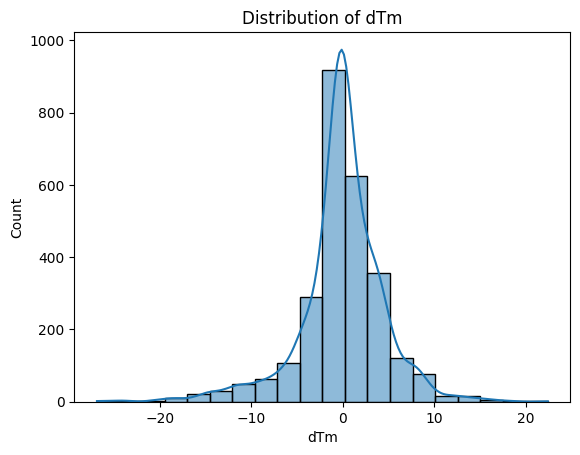

In [18]:
sns.histplot(df['dTm'], bins=20, kde=True)
plt.xlabel('dTm')
plt.title('Distribution of dTm')
plt.show()

The dTM distribution values is between -20 to +20 withe the mean at 0.

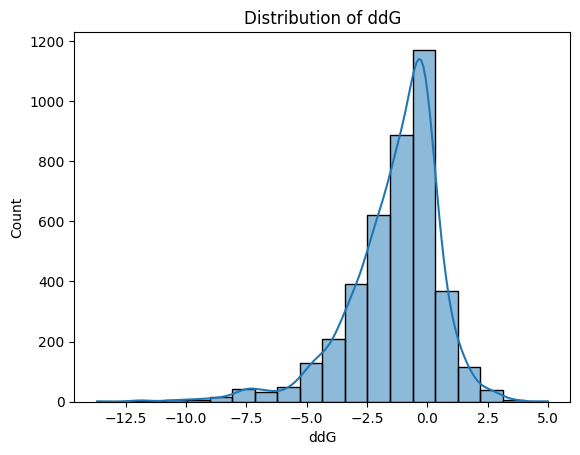

In [19]:
sns.histplot(df['ddG'], bins=20, kde=True)
plt.xlabel('ddG')
plt.title('Distribution of ddG')
plt.show()

The distribution of ddG is right-skewed, and majority of the value is between -2.5 to +2.5

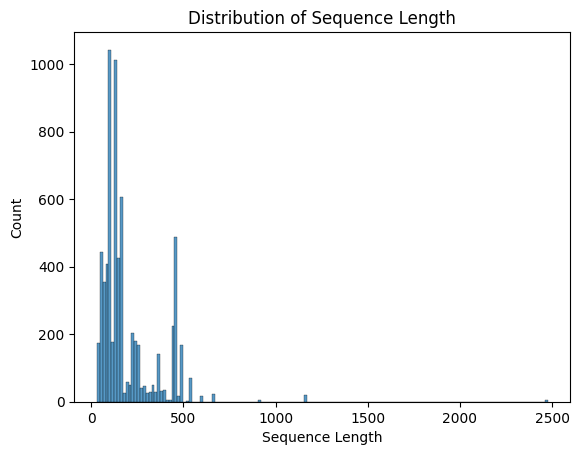

In [20]:
df['sequence_length'] = df['sequence'].apply(len)
sns.histplot(df['sequence_length'])
plt.xlabel('Sequence Length')
plt.title('Distribution of Sequence Length')
plt.show()

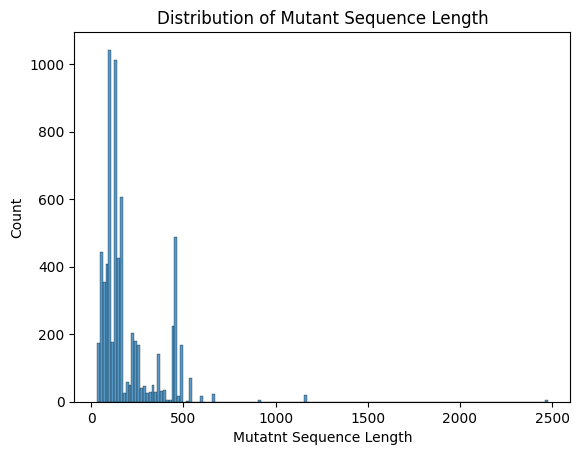

In [21]:
df['mutant_sequence_length'] = df['mutant_seq'].apply(len)
sns.histplot(df['mutant_sequence_length'])
plt.xlabel('Mutatnt Sequence Length')
plt.title('Distribution of Mutant Sequence Length')
plt.show()

In [22]:
from Bio.SeqUtils import ProtParam

def count_amino_acids(sequence):
    amino_acid_count = ProtParam.ProteinAnalysis(sequence).count_amino_acids()
    return amino_acid_count

df['amino_acid_count'] = df['sequence'].apply(count_amino_acids)
df.head(10)

,PDB,wildtype,position,mutation,ddG,sequence,mutant_seq,source,dTm,CIF,sequence_length,mutant_sequence_length,amino_acid_count
0,1A43,G,9,A,-1.00,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQAPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None,72,72,"{'A': 6, 'C': 2, 'D': 4, 'E': 6, 'F': 2, 'G': ..."
1,1A43,E,12,D,-2.10,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKDPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None,72,72,"{'A': 6, 'C': 2, 'D': 4, 'E': 6, 'F': 2, 'G': ..."
2,1A43,R,20,A,-3.00,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDAFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None,72,72,"{'A': 6, 'C': 2, 'D': 4, 'E': 6, 'F': 2, 'G': ..."
3,1A43,W,37,A,-0.70,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNAMTETLLVQN...,jin_train.csv,NaN,None,72,72,"{'A': 6, 'C': 2, 'D': 4, 'E': 6, 'F': 2, 'G': ..."
4,1A43,C,71,S,-2.30,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,TSILDIRQGPKEPFRDYVDRFYKTLRAEQASQEVKNWMTETLLVQN...,jin_train.csv,NaN,None,72,72,"{'A': 6, 'C': 2, 'D': 4, 'E': 6, 'F': 2, 'G': ..."
5,1A5E,W,15,D,0.17,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADDLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None,156,156,"{'A': 29, 'C': 1, 'D': 11, 'E': 11, 'F': 1, 'G..."
6,1A5E,L,37,S,0.71,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGASPNAPNSYGR...,jin_train.csv,NaN,None,156,156,"{'A': 29, 'C': 1, 'D': 11, 'E': 11, 'F': 1, 'G..."
7,1A5E,D,74,N,-2.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None,156,156,"{'A': 29, 'C': 1, 'D': 11, 'E': 11, 'F': 1, 'G..."
8,1A5E,P,81,L,0.00,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None,156,156,"{'A': 29, 'C': 1, 'D': 11, 'E': 11, 'F': 1, 'G..."
9,1A5E,D,84,N,-0.10,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,MEPAAGSSMEPSADWLATAAARGRVEEVRALLEAGALPNAPNSYGR...,jin_train.csv,NaN,None,156,156,"{'A': 29, 'C': 1, 'D': 11, 'E': 11, 'F': 1, 'G..."


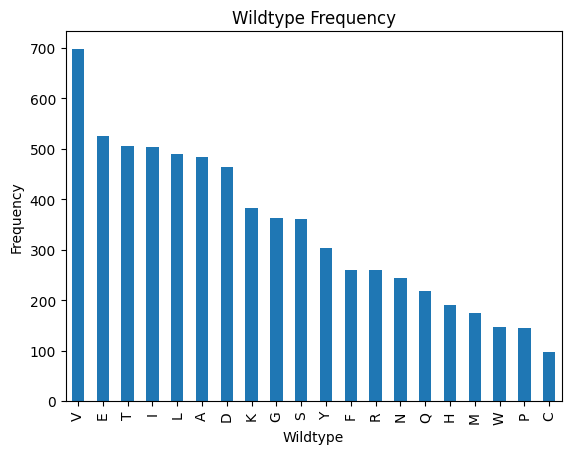

In [23]:
wildtype_counts = df['wildtype'].value_counts()
wildtype_counts.plot(kind='bar')
plt.title('Wildtype Frequency')
plt.xlabel('Wildtype')
plt.ylabel('Frequency')
plt.show()

The wildtype frequency graph will help determine what are common amino acid present in the sequence 

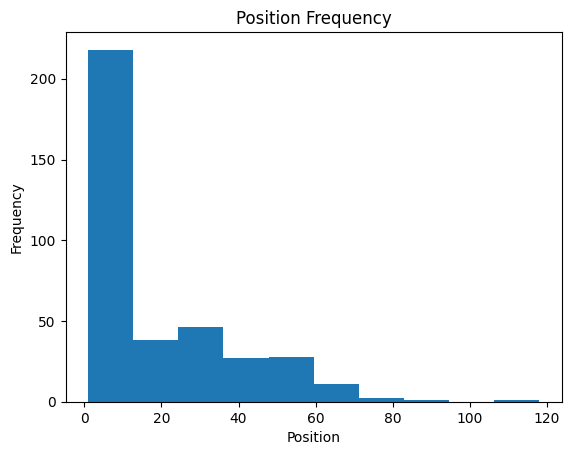

In [24]:
position_counts = df['position'].value_counts()
position_counts.plot(kind='hist')
plt.title('Position Frequency')
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.show()

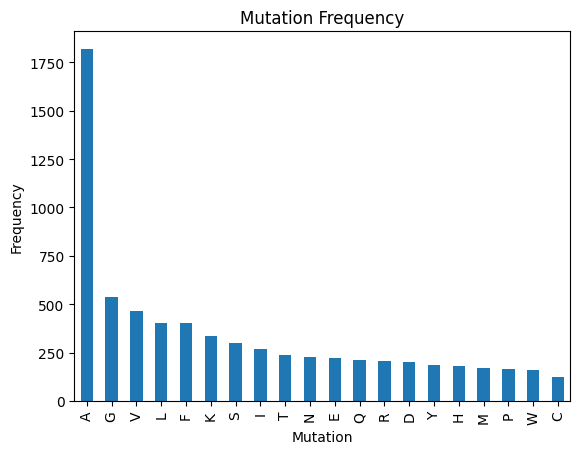

In [25]:
mutation_counts = df['mutation'].value_counts()
mutation_counts.plot(kind='bar')
plt.title('Mutation Frequency')
plt.xlabel('Mutation')
plt.ylabel('Frequency')
plt.show()

Mutation frequency help determine at what position of amino acid did mutation occur. Based on the graph, A is the most common amio acids where mutaion is occuring, which is Alanine

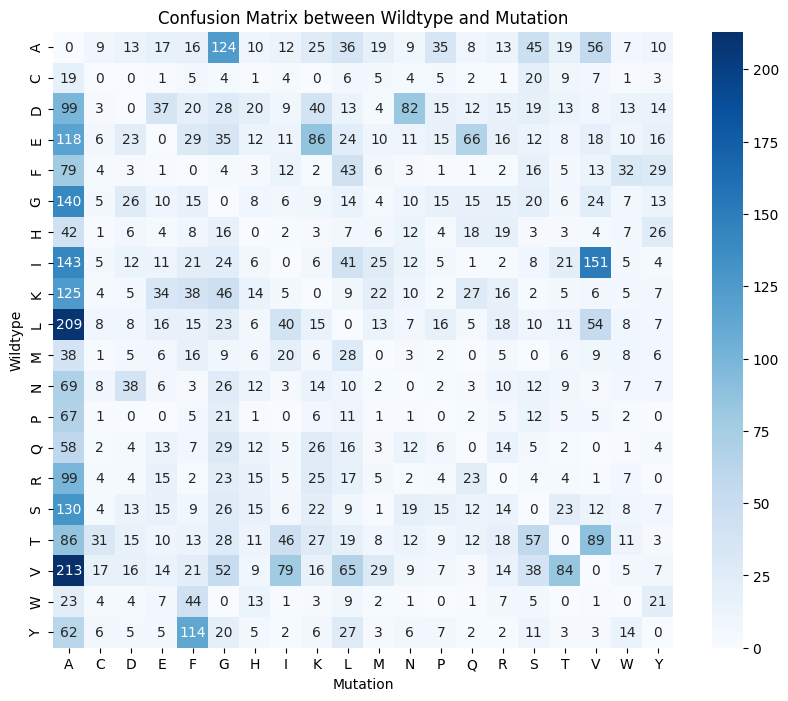

In [26]:
confusion_matrix = pd.crosstab(df['wildtype'], df['mutation'])

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix between Wildtype and Mutation')
plt.xlabel('Mutation')
plt.ylabel('Wildtype')
plt.show()

From the confusion matrix we can see taht V(Valine) and L(Leucine) wildtype is getting converted to A(Alanine).